# A2: Bias in the Data
Xiaolu Qian <br>
In this notebook, 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Step 0: Background and EDA
In this session, I will walk you through some visualizations and distributions for the demographic information of crowdflower workers who labeled toxicity and aggression. Those simple EDA helped me to think about the bias in data problem that I want to solve. 

Load the data related to toxicity and aggression

In [31]:
# data for toxicity 
demographic_worker = pd.read_csv('toxicity_data/toxicity_worker_demographics.tsv',  sep = '\t')
annotated_comments = pd.read_csv('toxicity_data/toxicity_annotated_comments.tsv',  sep = '\t')
annotations = pd.read_csv('toxicity_data/toxicity_annotations.tsv',  sep = '\t')

# data for aggression
demographic_worker_agg = pd.read_csv('~/Desktop/aggression_data/aggression_worker_demographics.tsv',  sep = '\t')
annotated_comments_agg = pd.read_csv('~/Desktop/aggression_data/aggression_annotated_comments.tsv',  sep = '\t')
annotations_agg = pd.read_csv('~/Desktop/aggression_data/aggression_annotations.tsv',  sep = '\t')

Show percentage of the gender distribution of the workers who labeled toxicity 

In [35]:
demographic_worker.gender.value_counts('female')

male      0.648009
female    0.351713
other     0.000278
Name: gender, dtype: float64

Show percentage of the gender distribution of the workers who labeled aggression

In [100]:
demographic_worker_agg.gender.value_counts('female')

male      0.615982
female    0.383562
other     0.000457
Name: gender, dtype: float64

Show the count of workers in each gender for toxicity

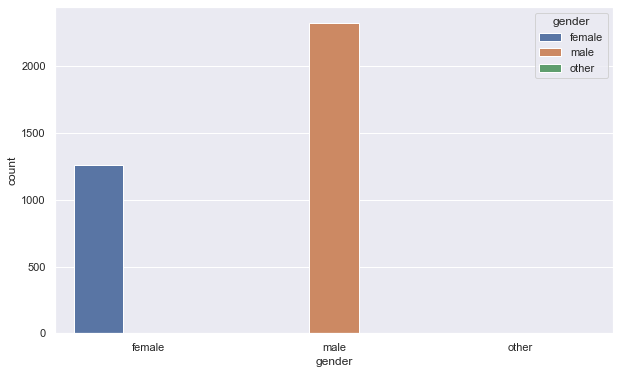

In [102]:
sns.set(rc={'figure.figsize':(10,6)})
sns.countplot(x="gender", hue="gender", data=demographic_worker)

Show percentage of the age group distribution of the workers for toxicity through visualization 

In [104]:
df= demographic_worker.age_group.value_counts('age_group')*100
worker_age_df = pd.DataFrame({'age_group':df.index, 'proportion':df.values})
df

18-30       52.988048
30-45       35.486625
45-60        8.423449
Under 18     2.248150
Over 60      0.853728
Name: age_group, dtype: float64

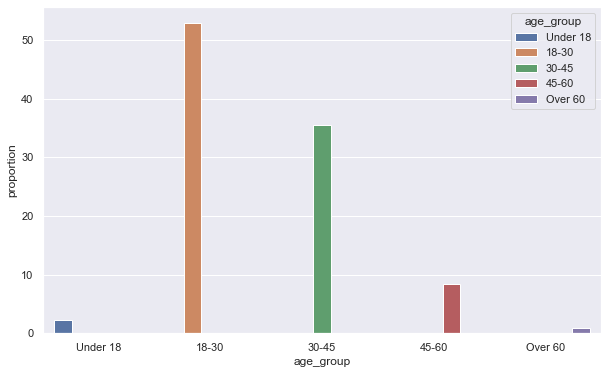

In [43]:
sns.set(rc={'figure.figsize':(10,6)})
sns.barplot(x="age_group", y = "proportion", hue="age_group", data=worker_age_df, 
            hue_order = ['Under 18','18-30', '30-45', '45-60', 'Over 60'],
            order = ['Under 18','18-30', '30-45', '45-60', 'Over 60'])

Show percentage of the age-bucket distribution of the workers who labeled aggression

In [106]:
agg_df= demographic_worker_agg.age_group.value_counts('age_group')*100
worker_age_df_agg = pd.DataFrame({'age_group':agg_df.index, 'proportion':agg_df.values})
agg_df

18-30       48.677494
30-45       38.561485
45-60       10.116009
Under 18     1.716937
Over 60      0.928074
Name: age_group, dtype: float64

## Step 1: Analysis
There are two anlysis that I would like to do. First, I want to furthur analyze the demographic information about the Crowdflower workers that is available in the dataset and answering the questions as the follwoing: How well does the demographic profile of the crowdworkers match that of the general population? What are some potential consequences of skewed labeller demographic distribution on the behavior of a model trained on this dataset? 

The second analysis I want to do is to explore relationships between worker demographics and labeling behavior. I would like to answer the questions as the following: Are female-identified labelers more or less likely to label comments as aggressive than male-identified labelers? If the labelling behaviors are different, what are some possible causes and consequences of this difference?

I will be using both the toxicity data and the aggression data for my analysis here. 

### Analysis 1

In the first analysis, I would like to compare the demographic information about the crowflower workers who labeled the toxicity data and aggression data with the demographic information of the general population. Here are the overview of the steps I took: 

- Find the gender distribution data and the age distribution information of the general population from UN's data 
- Choose the year 2015 since the age and gender distribution stays fairly constant in a range of years
- Perform data manipulation to compare the demographic information of the general public with the crowflowers'

Load the age distribution data download from UN's website

In [112]:
xls = pd.ExcelFile('PopulationAgeSex-20201019065126.xlsx')
population_age_df = pd.read_excel(xls, 'Data')

Perform data manipulation to be able to match with the age-bucket in our crowdflower workers' data. 

In [113]:
population_age_df = population_age_df.iloc[[13]]
population_age_df = population_age_df.drop(columns=['ISO 3166-1 numeric code', 'Location', 'Time', 'Sex'])
population_age_df = pd.melt(population_age_df, var_name='age_group', value_name='population')


# define new age group for the UN data
age_group_population = ['Under 18', 'Under 18', 'Under 18', 'Under 18',
                       '18-30', '18-30', '30-45', '30-45', '30-45', 
                       '45-60', '45-60','45-60',
                       'Over 60', 'Over 60', 'Over 60', 'Over 60', 'Over 60', 'Over 60', 'Over 60', 'Over 60', 'Over 60'] 

population_age_df['age_group_population'] = age_group_population
population_age_df

,age_group,population,age_group_population
0,0-4,670674,Under 18
1,5-9,644706,Under 18
2,10-14,615946,Under 18
3,15-19,601644,Under 18
4,20-24,597563,18-30
5,25-29,609086,18-30
6,30-34,550414,30-45
7,35-39,500480,30-45
8,40-44,487733,30-45
9,45-49,456777,45-60


In [114]:
# drop the unused column
new_population_age_df = population_age_df.drop(columns = ['age_group'])

In [115]:
# calculate the distribution of propotion of each age group 
world_demographic = new_population_age_df.groupby('age_group_population').agg('sum')['population']/new_population_age_df.sum()['population']*100
world_demographic

age_group_population
18-30       16.350703
30-45       20.849172
45-60       16.259996
Over 60     12.217108
Under 18    34.323022
Name: population, dtype: float64

In [116]:
# reformat the poportion into a dataframe 
world_demographic = pd.DataFrame({'age_group':world_demographic.index, 'world_proportion':world_demographic.values})
world_demographic

,age_group,world_proportion
0,18-30,16.350703
1,30-45,20.849172
2,45-60,16.259996
3,Over 60,12.217108
4,Under 18,34.323022


We can now compare the distribution of age group of workers who labeled toxicity vs the general population

In [117]:
worker_vs_world_age_df = world_demographic.merge(worker_age_df, on = 'age_group')
worker_vs_world_age_df

,age_group,world_proportion,proportion
0,18-30,16.350703,52.988048
1,30-45,20.849172,35.486625
2,45-60,16.259996,8.423449
3,Over 60,12.217108,0.853728
4,Under 18,34.323022,2.248150


We now repeat the same procedure for comparing the distribution of age group of workers who labeled aggression vs the general population

In [118]:
agg_worker_vs_world_age_df = world_demographic.merge(worker_age_df_agg, on = 'age_group')
agg_worker_vs_world_age_df

,age_group,world_proportion,proportion
0,18-30,16.350703,48.677494
1,30-45,20.849172,38.561485
2,45-60,16.259996,10.116009
3,Over 60,12.217108,0.928074
4,Under 18,34.323022,1.716937


### Analysis 1 findings

From UN's data, I find the demographic distribution for age-group and gender for the year 2015. I did some data manipulation for the age-group to match up with the age-group in the dataset. For gender information (https://population.un.org/wpp/DataQuery/), male vs female ratio is 101.7 : 100 which is distributed evenly. Compared to the demographic info for the crowdflower workers, we see a very uneven distribution across gender and age-group population distribution. Workers who labeled for toxicity data and aggression data shows the same skewed demographic information. The demographic profile of the crowdflower workers do not match that of the general population well at all. We see that there are twice as much male crowdflower workers than females. We also see that there are a lot more younger people over 18-year-old among workers than the proportion of this age group in the general population. Such bias in the demographic data of the workers is very obvious. 

We should pay attention to such bias in the data since it is possible that male vs female or young people vs old people have different level of sentiment when they label the wiki comments on a scale of -2 to 2 for both the toxicity and aggression datasets. Thus in our second analysis, we go furthur to analysis suh bias in the demographic profile of the crodflower workers. 

## Analysis 2

In this analysis, I will furthur explore the bias in the demographic profile of workers. I want to answer the question: are female-identified labelers more or less likely to label comments as aggressive than male-identified labelers? In order to answer this question, I followed the steps below:

- Merge annotations for toxicity with the corresponding worker demographic data and do the same thing for aggression data
- Calculate the conditional probability using Bayes' theorem for P(aggression level given female workers) and P(aggression level given male workers)
- Do the same thing for the toxicity data 


#### Aggression

Merge annotations for aggression with the corresponding worker demographic data 

In [119]:
annotations_agg_demo = annotations_agg.merge(demographic_worker_agg, on = 'worker_id')
annotations_agg_demo

,rev_id,worker_id,aggression,aggression_score,gender,english_first_language,age_group,education
0,37675,1362,1.0,-1.0,male,0,18-30,masters
1,3202092,1362,0.0,0.0,male,0,18-30,masters
2,4745553,1362,0.0,0.0,male,0,18-30,masters
3,4855563,1362,0.0,0.0,male,0,18-30,masters
4,8350378,1362,0.0,0.0,male,0,18-30,masters
...,...,...,...,...,...,...,...,...
855509,281960519,3964,0.0,1.0,male,0,Under 18,some
855510,289741535,3964,1.0,-1.0,male,0,Under 18,some
855511,392852210,3964,0.0,0.0,male,0,Under 18,some
855512,538094319,3964,0.0,0.0,male,0,Under 18,some


Find the porprotion of female and male who give aggression score < 0 for aggression data 

In [90]:
annotations_agg_new = annotations_agg_demo[annotations_agg_demo['aggression_score'] < 0]

In [93]:
annotations_agg_new.gender.value_counts('female')

male      0.613188
female    0.386576
other     0.000236
Name: gender, dtype: float64

Calculate the joint probability for female/male and aggression score < 0 

In [121]:
print('P(aggression < 0 and gender = female): {}'.format(len(annotations_agg_new) * 0.386576 / len(annotations_agg_demo)))

P(aggression < 0 and gender = female): 0.0708369158377303


In [122]:
print('P(aggression < 0 and gender = male): {}'.format(len(annotations_agg_new) * 0.613188 / len(annotations_agg_demo)))

P(aggression < 0 and gender = male): 0.11236172641008796


Find the porprotion of female and male who give extreme aggression score = -2 

In [97]:
annotations_agg_neg2 = annotations_agg_demo[annotations_agg_demo['aggression_score'] == -2]
annotations_agg_neg2.gender.value_counts('female')

male      0.634996
female    0.364790
other     0.000214
Name: gender, dtype: float64

In [123]:
print('P(aggression = -2 and gender = female): {}'.format(len(annotations_agg_neg2) * 0.364790 / len(annotations_agg_demo)))

P(aggression = -2 and gender = female): 0.01595882163237539


In [124]:
print('P(aggression = -2 and gender = male): {}'.format(len(annotations_agg_neg2) * 0.634996 / len(annotations_agg_demo)))

P(aggression = -2 and gender = male): 0.027779785359444732


Below is what we calculated before for p(female) worker in the aggression dataset. 

In [92]:
annotations_agg_demo.gender.value_counts('female')

male      0.639765
female    0.360138
other     0.000097
Name: gender, dtype: float64

We use the Bayes' theorem to figure how the condition probability: P(aggression_score < 0 | gender = female) and P(aggression_score < 0 | gender = male). <br>


\begin{equation*}
P(aggression < 0 | gender = female/male) = 
\frac{P(aggression < 0 \cap gender = female/male)}{P(gender = female/male)}
\end{equation*} <br>

\begin{equation*}
P(aggression < 0 | gender = female) = 
\frac{0.0708369}{0.360138} = 0.19667
\end{equation*} 

\begin{equation*}
P(aggression < 0 | gender = male) = 
\frac{0.1123617}{0.639765} = 0.1756
\end{equation*} 

We calculate the conditional probability also for the extreme aggressive scores

\begin{equation*}
P(aggression = -2 | gender = female) = 
\frac{0.016}{0.360138} = 0.044
\end{equation*} 

\begin{equation*}
P(aggression = -2 | gender = male) = 
\frac{0.028}{0.639765} = 0.044
\end{equation*} 

#### Toxicity
We now do the same thing for the toxicity data

In [126]:
annotations_demo = annotations.merge(demographic_worker, on = 'worker_id')

Find the porprotion of female and male who give toxicty score < 0

In [128]:
annotations_new = annotations_demo[annotations_demo['toxicity_score'] < 0]
annotations_new.gender.value_counts('female')

male      0.633697
female    0.366003
other     0.000301
Name: gender, dtype: float64

Calculate the joint probability for female/male and toxicity score < 0 

In [131]:
print('P(toxicity < 0 and gender = female): {}'.format(len(annotations_new) * 0.366003 / len(annotations_demo)))

P(toxicity < 0 and gender = female): 0.05333958662093389


In [132]:
print('P(toxicity < 0 and gender = male): {}'.format(len(annotations_new) * 0.633697 / len(annotations_demo)))

P(toxicity < 0 and gender = male): 0.09235207367952158


Find the porprotion of female and male who give extreme toxicity score = -2 

In [133]:
annotations_neg2 = annotations_demo[annotations_demo['toxicity_score'] == -2]
annotations_neg2.gender.value_counts('female')

male      0.608083
female    0.391500
other     0.000417
Name: gender, dtype: float64

In [134]:
print('P(toxicity = -2 and gender = female): {}'.format(len(annotations_neg2) * 0.391500 / len(annotations_demo)))

P(toxicity = -2 and gender = female): 0.01045023107676203


In [135]:
print('P(toxicity = -2 and gender = male): {}'.format(len(annotations_neg2) * 0.608083 / len(annotations_demo)))

P(toxicity = -2 and gender = male): 0.01623143771098515


Below is what we calculated before for p(female) worker in the toxicity dataset. 

In [136]:
annotations_demo.gender.value_counts('female')

male      0.660194
female    0.339541
other     0.000266
Name: gender, dtype: float64

We use the Bayes' theorem to figure how the condition probability: P(toxicity_score < 0 | gender = female) and P(toxicity_score < 0 | gender = male). <br>


\begin{equation*}
P(toxicity < 0 | gender = female/male) = 
\frac{P(toxicity < 0 \cap gender = female/male)}{P(gender = female/male)}
\end{equation*} <br>

\begin{equation*}
P(toxicity < 0 | gender = female) = 
\frac{0.053}{0.339541} = 0.156
\end{equation*} 

\begin{equation*}
P(toxicity < 0 | gender = male) = 
\frac{0.092}{0.660194} = 0.139
\end{equation*} 

\begin{equation*}
P(toxicity = -2 | gender = female) = 
\frac{0.01045}{0.339541} = 0.031
\end{equation*} 

\begin{equation*}
P(toxicity = -2 | gender = male) = 
\frac{0.016}{0.660194} = 0.024
\end{equation*} 

### Analysis 2 findings

Under the assumption that workers are randomly selected to do the annotations for toxicity data and the aggression data, we see that suprising, female-identified labelers are equally likely to label comments as aggressive than male-identified labelers. Based on the results of the conditional probability we have, we see P(toxicity_score/aggression_score < 0 | gender = female) and P(toxicity_score/aggression < 0 | gender = male) are very similar to each other. When I compared the extreme comments with aggression_score = -2 and toxicty_score = -2, we still see no difference between female-identified labelers and male identified labelers. P(toxicity_score/aggression = -2 | gender = female) and P(toxicity_score/aggression_score = -2 | gender = male) are very similar. 

I conclude that female-identified labelers are equally likely to label comments as aggressive than male-identified labelers. Thus gender disproportion does not contribute to the bias in the data. We do not need to worry about that. However, I believe the age-group demographic profile of workers would make a difference. If more time is granted, furthur analysis on the age-group should be done.

## Step 2: Future implications

1. Which, if any, of these demo applications would you expect the Perspective API to perform poorly in? Why?

We might not forsee the bias in the demographic data beside gender of the Crowdflower workers. I suspect that there is bias towards the proportion of young people in the worker population dominates the likelyhood to label comments as aggressive. Thus the API such as Comment Filter might have high false positive errors. 

2. Imagine you are one of the Google data scientists who maintains the Perspective API. If you wanted to improve the model or the API itself to make it work better for any of these purposes, how should they go about doing that?

We should take a deeper investigation towards the potential bias in the demographic of workers. There are a lot more to explore besides age-group. Since all the comments were in English and only 17% of the annotators said they speak English as their first language there might be some error in interpretation of the comments. This data also grouped annotators by age into ranges of 15, grouping by a smaller range might produce different results. We would want to weight the aggression/toxicity scores of the comments axcording to out furthur analysis. 

3. What are some potential unintended, negative consequences of using the Perspective API for any of these purposes? In your opinion, are these consequences likely or serious enough that you would recommend that the Perspective API not be used in these applications? Why or why not?

some potential unintended, negative consequences of using the Perspective API could be both the type I and the type II error. The API falsely accusing a person of being a negative user on a specific platform or missing a toxic user thus allowing them to stay on the platform. 
